In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/dataset/Dataset + Code"

/content/drive/.shortcut-targets-by-id/15Dy4rnq97kGrOnobE1znPX1oussvbDa5/Dataset + Code


In [ ]:
# Thanh Long's
%cd "/content/drive/MyDrive/Đồ án/CS313/Đồ án/Dataset + Code"

/content/drive/MyDrive/Đồ án/CS313/Đồ án/Dataset + Code


In [ ]:
import os
import pandas as pd
import numpy as np
from duckdb import query as dbquery
import seaborn as sbn
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pandas.plotting import autocorrelation_plot

In [ ]:
def transposeDataFrame(df, col_name, start_idx):
  df2 = pd.DataFrame(df.values[:, start_idx:].astype(np.float64).T, columns=df[col_name].to_list())
  df2.insert(loc=0, column='timestep', value=df.columns[start_idx:])
  return df2

In [ ]:
dataset = list(filter(lambda x: x[-4:] == ".csv", os.listdir('.')))

In [ ]:
irrelevant_cols = ['ISO2', "ISO3", "Source", "CTS Name", "CTS Code", 'CTS Full Descriptor']

In [ ]:
data = []
for f in dataset:
  df = pd.read_csv(f).drop(columns=irrelevant_cols, errors='ignore')
  data.append(df)

In [ ]:
countries = []
for d in data:
  countries.extend(d['Country'])

In [ ]:
truncated_data = []
for d in data:
  truncated_data.append(dbquery("Select * from d where country = 'World';").to_df().drop(columns=['Country']))

## Data metadata
### Dataset:
1. Renewable Energy
2. Surface temperature
3. Land cover
4. Disasters
5. Greenhouse gases
6. CO2 Concentration
7. Mean sea level
8. Forest and carbon

In [ ]:
truncated_data[2]['Indicator'] = truncated_data[2]['Indicator'] + "/" + truncated_data[2]['Climate Influence']

In [ ]:
preprocessed_dataframes = [
  transposeDataFrame(truncated_data[0].query('Indicator == "Electricity Generation"'), "Technology", 4).dropna(),
  transposeDataFrame(truncated_data[1], 'Unit', 2).rename({"Unit": "temperature"}),
  transposeDataFrame(truncated_data[2], "Indicator", 3)
]

In [ ]:

disasters = data[3].drop(columns=['Unit', 'Country'])
disasters = disasters.groupby(['Indicator'], as_index=False).agg('sum')
disasters['Indicator'] = disasters['Indicator'].map(lambda x: x.split(': ')[-1])
preprocessed_dataframes.append(transposeDataFrame(disasters, "Indicator", 1).drop(columns=['TOTAL']))

In [ ]:
d = truncated_data[4].query("`Seasonal Adjustment` == 'Seasonally Adjusted'").drop(columns=['Unit', 'Indicator', 'Seasonal Adjustment', 'Scale'])
d = d.groupby('Gas Type', as_index=False).agg('sum')
d2 = transposeDataFrame(d, 'Gas Type', 2)
d2['timestep'] = d2['timestep'].map(lambda x: x[:4])
preprocessed_dataframes.append(d2.groupby('timestep', as_index=False).agg('mean'))

In [ ]:
co2 = truncated_data[5].drop(columns=['Indicator'])
preprocessed_dataframes.append(dbquery('''
select substring(Date, 1, 4) timestep, avg(Value) co2_ppm
from co2
where unit like 'Parts%'
group by timestep
order by timestep;
''').to_df())

In [ ]:
def toISO8601(st):
  month = st[1:3]
  day = st[4:6]
  year = st[7:11]
  return f"{year}-{month}-{day}"

truncated_data[6]['Date'] = truncated_data[6]['Date'].map(toISO8601)
truncated_data[6]['Indicator'] = truncated_data[6]["Indicator"].map(lambda x: x.split(' ')[-1])

In [ ]:
sea = truncated_data[6]
mean_sea_by_year = dbquery('''
select substring(date, 1, 4) timestep, avg(Value) sea_level
from sea
where Indicator != 'Trend' and timestep != '1992'
group by timestep
order by timestep asc;
''').to_df()
preprocessed_dataframes.append(mean_sea_by_year)

In [ ]:
preprocessed_dataframes.append(transposeDataFrame(truncated_data[7].query('Unit == "1000 HA"'), "Indicator", 2))

In [ ]:
joined_data = None
for sub_df in preprocessed_dataframes:
  sub_df['timestep'] = sub_df['timestep'].astype(np.int32)
  if joined_data is None:
    joined_data = sub_df.set_index('timestep')
  else:
    joined_data = joined_data.join(sub_df.set_index('timestep'), how='outer')

In [ ]:
df = joined_data
df

,Bioenergy,Fossil fuels,Geothermal energy,Hydropower (excl. Pumped Storage),Marine energy,Nuclear,Other non-renewable energy,Pumped storage,Solar energy,Wind energy,...,Wildfire,Carbon dioxide,Fluorinated gases,Greenhouse gas,Methane,Nitrous oxide,co2_ppm,sea_level,Forest area,Land area
timestep,,,,,,,,,,,,,,,,,,,,,
1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,315.232000,NaN,NaN,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,315.980833,NaN,NaN,NaN
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,316.910000,NaN,NaN,NaN
1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,317.644167,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,318.454167,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,572041.610,1.656223e+07,94645.217,4357351.497,983.975,2679742.086,150192.309,120370.133,842411.926,1588655.688,...,9.0,17612.222483,502.619365,24523.723881,5116.883504,1291.998530,414.210833,80.437216,4058927.05,1.302624e+07
2021,614023.268,1.742686e+07,95251.031,4275354.865,970.024,2789348.256,165641.040,125304.326,1033925.733,1838662.870,...,19.0,18628.828182,528.295421,25661.844920,5190.441027,1314.280290,416.413333,82.428703,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,18795.441377,558.305781,25972.791310,5299.940441,1319.103714,418.528333,88.991610,NaN,NaN


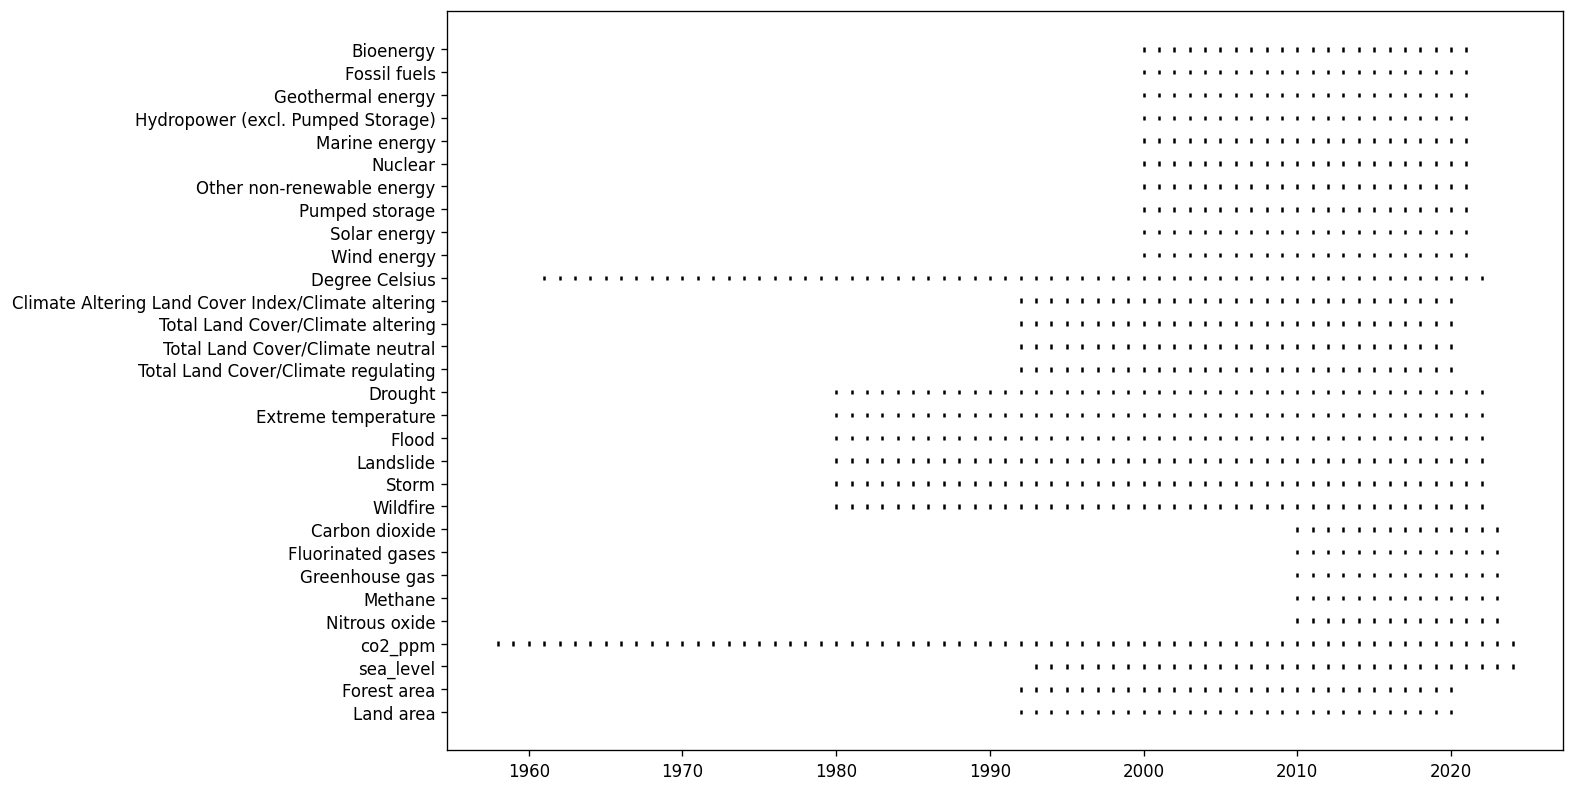

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=120)
for i, col in enumerate(df.columns):
  ax.eventplot(df.index[~df[col].isna()].astype(int).to_list(), lineoffsets=i, linelengths=0.2, color='black')
ax.invert_yaxis()
ax.set_yticks(list(range(len(df.columns))))
_ = ax.set_yticklabels(df.columns)

In [ ]:
def pearson(a, b, dt):
  c = a
  d = b
  if dt < 0:
    (c, d) = (b, a)
    dt *= -1
  c = c[dt:]
  if dt != 0:
    d = d[:-dt]
  mask = ~(np.isnan(c) | np.isnan(d))
  c = c[mask]
  d = d[mask]
  if len(c) < 5:
    return 0
  return pearsonr(c, d).statistic

In [ ]:
corrs = []
for col in df.columns:
  r = []
  for col2 in df.columns:
    t = []
    for dt in range(-10, 11):
      t.append(pearson(df[col].values, df[col2].values, dt))
    r.append(t)
  corrs.append(r)

In [ ]:
corrs = np.array(corrs)

Text(0.5, 1.0, 'Correlation of each feature to surface temperature across different lags')

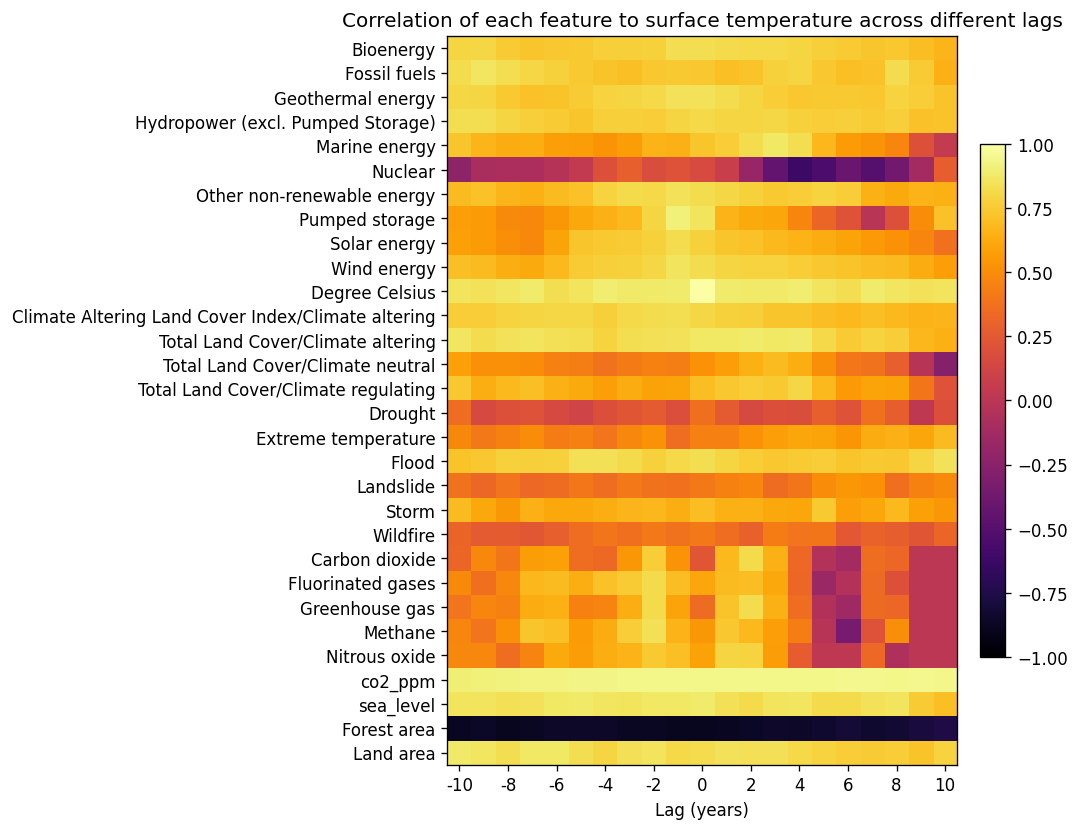

In [ ]:
plt.figure(figsize=(6, 10), dpi=120)
im = plt.imshow((corrs[10, :, :]), vmin=-1, vmax=1, cmap='inferno')
plt.yticks(range(0, 30), labels=df.columns)
plt.xticks(range(0, 21, 2), labels=range(-10, 11, 2))
plt.xlabel("Lag (years)")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("Correlation of each feature to surface temperature across different lags")

Text(0.5, 1.0, 'Correlation of climate-related disaster feature to surface temperature across different lags')

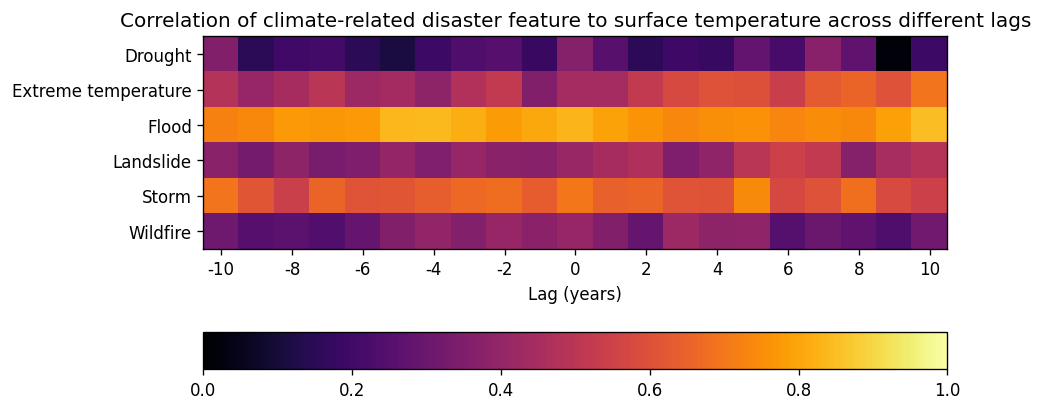

In [ ]:
plt.figure(figsize=(8, 6), dpi=120)
im = plt.imshow((corrs[10, 15:21, :]), vmin=0, vmax=1, cmap='inferno')
plt.yticks(range(0, 6), labels=df.columns[15:21])
plt.xticks(range(0, 21, 2), labels=range(-10, 11, 2))
plt.xlabel("Lag (years)")
plt.colorbar(im,orientation='horizontal')
plt.title("Correlation of climate-related disaster feature to surface temperature across different lags")

In [ ]:
elnino = pd.read_csv("/content/El-Nino.csv")
elnino = elnino.set_index('Year', drop=True)

array([  5.5,  17.5,  29.5,  41.5,  53.5,  65.5,  77.5,  89.5, 101.5,
       113.5, 125.5, 137.5, 149.5, 161.5, 173.5, 185.5, 197.5, 209.5,
       221.5, 233.5, 245.5, 257.5, 269.5])

In [ ]:
len(nino)

276

In [ ]:
def interpolate(t, inner_range):
  l = (inner_range-1) * (len(t) - 1) + len(t)
  out = np.zeros(l)
  start = t[0]
  out[0] = start
  for i in range(1, len(t)):
    next = t[i]
    for j in range(1, inner_range+1):
      out[(i-1)*inner_range + j] = j/inner_range * next + (1 - j/inner_range)*start
    start = next
  return out

Text(0.5, 1.0, 'Drought counts and El niño index relation')

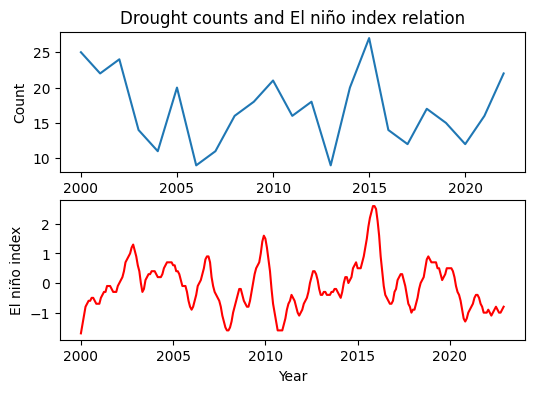

In [ ]:
nino = elnino.loc[2000:2022].values.flatten()
drought2000 = df['Drought'].dropna().values[20:]

fig, axes = plt.subplots(2, 1, figsize=(6, 4))
ax = axes[0]
ax2 = axes[1]
ax.plot(np.arange(2000, 2023), drought2000)
ax2.plot(np.arange(276), nino, color='red')
ax2.set_xticks(np.arange(0, 277, 12*5))
ax2.set_xticklabels(np.arange(2000, 2023, 5))
ax2.set_xlabel("Year")
ax.set_ylabel("Count")
ax2.set_ylabel("El niño index")
ax.set_title("Drought counts and El niño index relation")

In [ ]:
drought_ex = interpolate(drought2000, 12)[:-1]
nino = elnino.loc[2000:2021].values.flatten()
corr = []
for i in range(-10, 11):
  corr.append(pearson(nino, drought_ex, i))

In [ ]:
corr

[-0.3533399637551289,
 -0.3284489261677681,
 -0.3003295182792985,
 -0.2698981222338288,
 -0.23836161304390016,
 -0.2058938664727734,
 -0.17262383643289117,
 -0.13865221567777072,
 -0.10383104222055987,
 -0.06930109607844352,
 -0.03508868289727348,
 0.0204342085847643,
 0.07347800209150653,
 0.12363384618451143,
 0.16911529556134505,
 0.21073287266997065,
 0.24755485648311717,
 0.28024239318016675,
 0.3066942052884566,
 0.32685873196059445,
 0.3412984548016126]

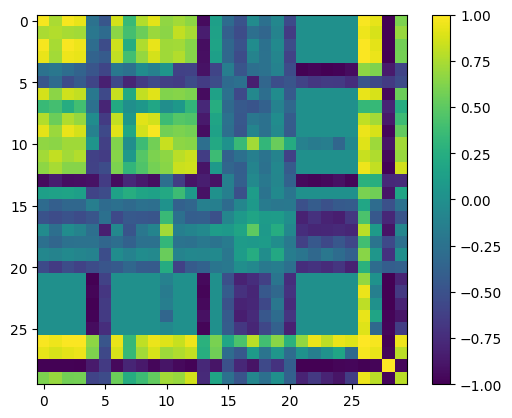

In [ ]:
plt.imshow(corrs.min(axis=2), vmin=-1, vmax=1)
plt.colorbar()

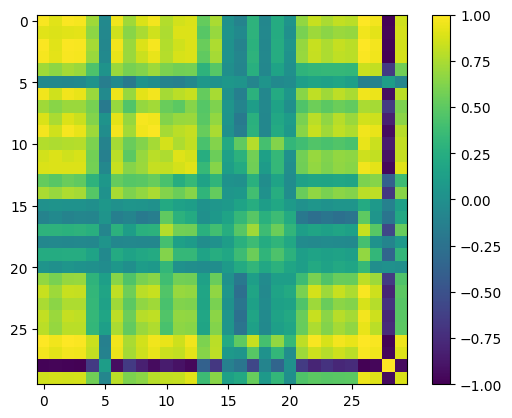

In [ ]:
plt.imshow(corrs.mean(axis=2), vmin=-1, vmax=1)
plt.colorbar()

Text(0.5, 1.0, 'Cross-correlation between Forest area and Surface temperature change')

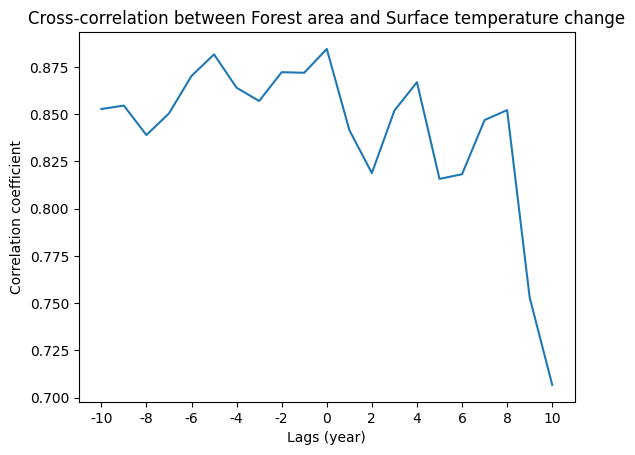

In [ ]:
plt.plot(corrs[10, -3, :])
plt.xticks(range(0, 21, 2), labels=range(-10, 11, 2))
plt.xlabel("Lags (year)")
plt.ylabel("Correlation coefficient")
plt.title("Cross-correlation between Forest area and Surface temperature change")

In [ ]:
data[3]['Indicator'] = data[3]['Indicator'].map(lambda x: x.split(': ')[-1])

In [ ]:
drought_df = data[3].query('Indicator == "Drought"').fillna(0).drop(columns=['Indicator', 'Unit'])

In [ ]:
df['Degree Celsius'].dropna().index

Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022],
      dtype='int32', name='timestep')

In [ ]:
ref = df['Degree Celsius'].dropna().values[19:]

In [ ]:
lag_analyze = {}
for i in range(len(drought_df)):
  series = drought_df.iloc[i]
  country = series['Country']
  values = series.values[1:].astype(int)
  pr = []
  for j in range(-10, 11):
    pr.append(pearson(values, ref, j))
  lag_analyze[country] = pr

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import  ValueWarning
import warnings
warnings.simplefilter('ignore', ValueWarning)

In [ ]:
warnings.simplefilter('ignore', FutureWarning)

In [ ]:
def arima_autocorelate(series):
  autocorrelation_plot(series.dropna())

def arima_extrapolate(series, order, n, log=True):
  model = ARIMA(series.dropna(), order=order)
  model_fit = model.fit()
  if log:
    print(model_fit.summary())
  pred = series.dropna()
  # t = model_fit.forecast(n)
  lasttime = series.index[-1]
  forecasted = model_fit.forecast(n)
  forecasted = pd.concat((pd.Series([series.values[-1]]), forecasted))
  forecasted.index = list(range(lasttime, lasttime+len(forecasted)))
  return forecasted

In [ ]:
def smooth(arr, alpha=0.2):
  x0 = arr[0]
  out = [x0]
  for x in arr[1:]:
    x0 = x0*(1-alpha) + x*alpha
    out.append(x0)
  return out

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


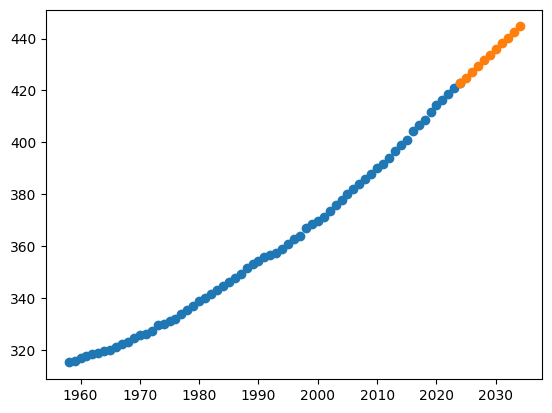

In [ ]:
colname = 'co2_ppm'
p1 = arima_extrapolate(df[colname], (10, 1, 0), 10, log=False)
plt.scatter(df[colname].index, df[colname].values)
plt.scatter(p1.index, p1.values)

In [ ]:
def evaluate(colname, hyper):
  d = df[colname].dropna()
  p1 = arima_extrapolate(d.iloc[:-5], hyper, 5, log=False)
  target = d.values[-5:]
  predict = p1.values[1:6]
  return (np.abs(target - predict)/target).mean()

In [ ]:
for i in range(15):
  print(i, evaluate('Degree Celsius', (i, 1, 0)))

0 0.06410055616688744
1 0.09177588103967382
2 0.09386072550716129
3 0.058927848337294586
4 0.08005463579534396
5 0.09963519728879369
6 0.08149991093343593
7 0.08503269192556713
8 0.08103713032051446
9 0.09649650043203542
10 0.09775165655785269
11 0.07990353041445898
12 0.07345994602880268
13 0.07467811587756491
14 0.07680213944722872


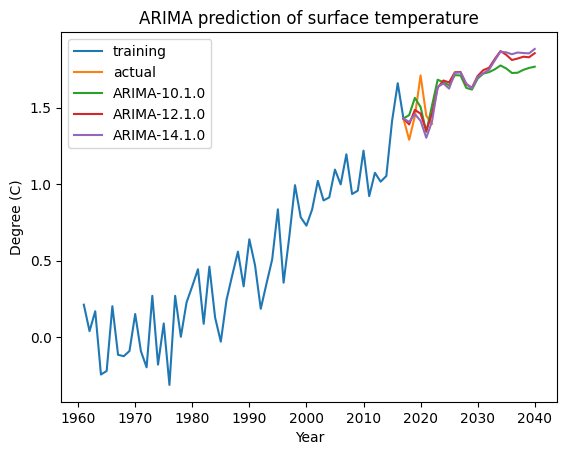

In [ ]:
colname = 'Degree Celsius'
d = df[colname].dropna()
p1 = arima_extrapolate(d.iloc[:-5], (12, 1, 0), 23, log=False)
p3 = arima_extrapolate(d.iloc[:-5], (10, 1, 0), 23, log=False)
p4 = arima_extrapolate(d.iloc[:-5], (14, 1, 0), 23, log=False)
plt.plot(d.index[:-5], d.values[:-5], label='training')
plt.plot(d.index[-6:], d.values[-6:], label='actual')
plt.plot(p3.index, p3.values, label='ARIMA-10.1.0')
plt.plot(p1.index, p1.values, label='ARIMA-12.1.0')
plt.plot(p4.index, p4.values, label='ARIMA-14.1.0')
plt.xlabel("Year")
plt.ylabel("Degree (C)")
plt.title("ARIMA prediction of surface temperature")
plt.legend()

In [ ]:
for i in range(15):
  print(i, evaluate('sea_level', (i, 1, 0)))

0 0.2308148796100295
1 0.22757559914084827
2 0.226882627024202
3 0.23118500807647707
4 0.1893637479950744
5 0.17171036157690828
6 0.1749175172873772
7 0.160481371682484
8 0.12522725921567246


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


9 0.13055329622175837


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


10 0.12872232922551105


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


11 0.131077310234423


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


12 0.13104414004458742


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


13 0.23081464036597982


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


14 0.23081463114331421


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


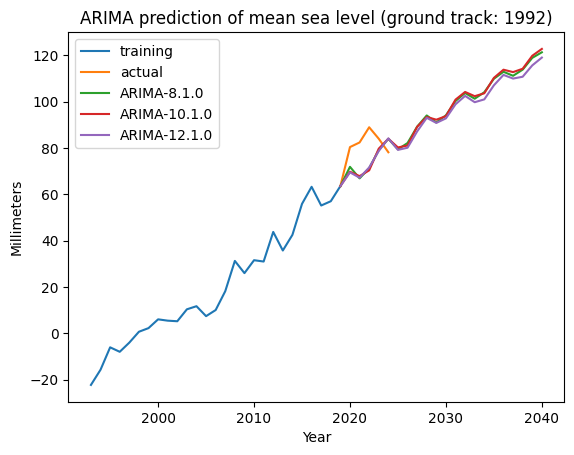

In [ ]:
colname = 'sea_level'
d = df[colname].dropna()
p1 = arima_extrapolate(d.iloc[:-5], (12, 1, 0), 21, log=False)
p3 = arima_extrapolate(d.iloc[:-5], (8, 1, 0), 21, log=False)
p4 = arima_extrapolate(d.iloc[:-5], (10, 1, 0), 21, log=False)
plt.plot(d.index[:-5], d.values[:-5], label='training')
plt.plot(d.index[-6:], d.values[-6:], label='actual')
plt.plot(p3.index, p3.values, label='ARIMA-8.1.0')
plt.plot(p4.index, p4.values, label='ARIMA-10.1.0')
plt.plot(p1.index, p1.values, label='ARIMA-12.1.0')
plt.xlabel("Year")
plt.ylabel("Millimeters")
plt.title("ARIMA prediction of mean sea level (ground track: 1992)")
plt.legend()

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
def outlier_investigate(column):
  model = IsolationForest(random_state = 0, contamination = float(0.05))
  t = model.fit_predict(df[[column]].dropna()) == -1
  d = df[column].dropna()
  plt.plot(d.index, d.values, zorder=1)
  plt.scatter(d.index[t], d.values[t], color='red', label='Outlier', zorder=5)
  plt.xlabel("Year")
  plt.legend()

## Forecasting Model



In [ ]:
# Drop highly correlated features
def drop_highly_correlated_features(df: pd.DataFrame, threshold: float, target: str) -> pd.DataFrame:
    corr_matrix = df.corr().abs()
    col_drop = list()
    iters = range (len(corr_matrix.columns)-1)

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                col_drop.append(col.values[0])

    drops = set(col_drop)
    if target in drops:
        drops.remove(target)
    df = df.drop(columns=drops)

    return df

###1. Long-Short Term Memory

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def get_data_predicted (data: pd.DataFrame, target):
  columns = data.columns
  data_add = dict()

  for column in columns:
    if column not in target:
      temp = data[column].dropna()
      predict_data = arima_extrapolate(temp.iloc[:-3], (8, 1, 0), 25, log=False).loc[2025:2040]
      data_add[column] = predict_data

  temp_df = df
  add_df = pd.DataFrame(data_add)
  return pd.concat([temp_df, add_df])

drop_columns = ['Drought', 'Flood', 'Storm', 'Landslide', 'Extreme temperature', 'Wildfire']
targets = ['sea_level', 'Degree Celsius']
new_df = df.drop(columns=drop_columns, axis=1)

predicted_temperature = get_data_predicted(new_df, 'Degree Celsius')
predicted_sea = get_data_predicted(new_df, 'sea_level')

# Eliminate the attribute has high correlation
predicted_temperature = drop_highly_correlated_features(predicted_temperature, 0.8, 'Degree Celsius')
predicted_sea = drop_highly_correlated_features(predicted_sea, 0.8, 'sea_level')

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

def preprocessing(data: pd.DataFrame, target):
  "Imputer the missing value and return X and y folder"
  temp = data.ffill().bfill()
  y = temp[target].to_numpy()
  X = temp.drop(columns=target, axis=1).to_numpy()
  return X, y

def df_to_window_df(data: pd.DataFrame, target, window_size = 5):
  """
  Function change df into windows data with window_size
  """
  from sklearn.preprocessing import StandardScaler

  # Apply filter with ffill().bfill()
  temp_df = data.ffill().bfill()

  # Get target
  targets = ['sea_level', 'Degree Celsius']
  label_data = temp_df[target].to_numpy()
  numpy_data = temp_df.drop(columns=target, axis=1).to_numpy()

  # Apply scale
  scaler = StandardScaler()
  numpy_data = scaler.fit_transform(numpy_data)

  # Apply fill the blank of data point
  X = []
  y = []
  for i in range (numpy_data.shape[0]-window_size):
    row = numpy_data[i:i+window_size]
    X.append(row)

    # Get one of this column is target:
    label = label_data[i:i+window_size]
    y.append(label)

  return np.array(X), np.array(y)

X_temperature, y_temperature = df_to_window_df(predicted_temperature, 'Degree Celsius', 5)
X_sea, y_sea = df_to_window_df(predicted_sea,'sea_level', 5)
X_temperature.shape, y_temperature.shape, X_sea.shape, y_sea.shape

((78, 5, 7), (78, 5), (78, 5, 7), (78, 5))

#### LSTM predicting sea level change

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.metrics import RootMeanSquaredError
from keras.losses import MeanSquaredError, MAPE, MeanAbsoluteError
from keras.optimizers import RMSprop

def create_LSTM(X, y):
  model = Sequential()
  model.add(LSTM(16, input_shape = (X.shape[1], X.shape[2])))
  model.add(Dense(1))
  model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mse'])
  return model

LSTM_model1 = create_LSTM(X_sea, y_sea)
LSTM_model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16)                1536      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1553 (6.07 KB)
Trainable params: 1553 (6.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Split data into train, test
X_train = X_sea[:62]
y_train = y_sea[:62]

# Validation
idx = 62
X_valid = X_train[56:]
y_valid = y_train[56:]

# Prediction
X_test = X_sea[62:]

cp = ModelCheckpoint ('./LSTM_model', save_best_only=True)
LSTM_model1.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=100, callbacks=[cp])

Epoch 1/100
2/2 [==============================] - 7s 5s/step - loss: 25.0660 - mse: 921.9130 - val_loss: 66.5602 - val_mse: 4588.8813
Epoch 2/100
2/2 [==============================] - 10s 10s/step - loss: 25.0244 - mse: 919.9301 - val_loss: 66.5373 - val_mse: 4585.7773
Epoch 3/100
2/2 [==============================] - 8s 8s/step - loss: 24.9843 - mse: 918.0617 - val_loss: 66.5156 - val_mse: 4582.8369
Epoch 4/100
2/2 [==============================] - 12s 12s/step - loss: 24.9447 - mse: 916.1736 - val_loss: 66.4939 - val_mse: 4579.9033
Epoch 5/100
2/2 [==============================] - 5s 5s/step - loss: 24.9044 - mse: 914.2816 - val_loss: 66.4726 - val_mse: 4577.0161
Epoch 6/100
2/2 [==============================] - 4s 4s/step - loss: 24.8614 - mse: 912.3179 - val_loss: 66.4506 - val_mse: 4574.0400
Epoch 7/100
2/2 [==============================] - 4s 4s/step - loss: 24.8210 - mse: 910.4088 - val_loss: 66.4292 - val_mse: 4571.1509
Epoch 8/100
2/2 [==============================] - 

In [ ]:
ypred_sea_LSTM = LSTM_model1.predict(X_test)
print(ypred_sea_LSTM)

1/1 [==============================] - 0s 435ms/step
[[1.2286757]
 [1.3911064]
 [1.325352 ]
 [1.3218498]
 [1.3000009]
 [1.2846509]
 [1.2789319]
 [1.2738086]
 [1.2688721]
 [1.2645805]
 [1.2604972]
 [1.2567867]
 [1.2533133]
 [1.2501476]
 [1.2472072]
 [1.244509 ]]


In [ ]:
Xdegree, ydegree = preprocessing(regression_temperature_data, 'Degree Celsius')
Xsea, ysea = preprocessing(regression_sea_data, 'sea_level')

Xtrain = Xsea[:62]
ytrain = ysea[:62]

# Metrics
ytrain_sea_LSTM = LSTM_model1.predict(X_train)
print ('MAPE_Sea Level Change:', mean_absolute_percentage_error(ytrain, ytrain_sea_LSTM))

2/2 [==============================] - 0s 20ms/step
MAPE_Sea Level Change: 0.7266051335980132


#### LSTM predicting temperature change

In [ ]:
LSTM_model2 = create_LSTM(X_temperature, y_temperature)
LSTM_model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 16)                1536      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1553 (6.07 KB)
Trainable params: 1553 (6.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Split data into train, test
X_train = X_temperature[:62]
y_train = y_temperature[:62]

# Validation
idx = 62
X_valid = X_train[56:]
y_valid = y_train[56:]

# Prediction
X_test = X_temperature[62:]

cp = ModelCheckpoint ('./LSTM_model2', save_best_only=True)
LSTM_model2.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=50, callbacks=[cp])

Epoch 1/50


2/2 [==============================] - 20s 4s/step - loss: 0.5906 - mse: 0.5882 - val_loss: 1.2745 - val_mse: 1.6586
Epoch 2/50
2/2 [==============================] - 5s 5s/step - loss: 0.5754 - mse: 0.5634 - val_loss: 1.2644 - val_mse: 1.6341
Epoch 3/50
2/2 [==============================] - 5s 5s/step - loss: 0.5602 - mse: 0.5385 - val_loss: 1.2539 - val_mse: 1.6086
Epoch 4/50
2/2 [==============================] - 5s 5s/step - loss: 0.5452 - mse: 0.5119 - val_loss: 1.2356 - val_mse: 1.5638
Epoch 5/50
2/2 [==============================] - 4s 4s/step - loss: 0.5327 - mse: 0.4884 - val_loss: 1.2170 - val_mse: 1.5186
Epoch 6/50
2/2 [==============================] - 5s 5s/step - loss: 0.5188 - mse: 0.4628 - val_loss: 1.1928 - val_mse: 1.4610
Epoch 7/50
2/2 [==============================] - 4s 4s/step - loss: 0.5051 - mse: 0.4364 - val_loss: 1.1672 - val_mse: 1.4011
Epoch 8/50
2/2 [==============================] - 4s 4s/step - loss: 0.4920 - mse: 0.4117 - val_loss: 1.1412 - val_mse: 1

In [ ]:
ypred_temperature_LSTM = LSTM_model2.predict(X_test)
print(ypred_temperature_LSTM)

1/1 [==============================] - 0s 423ms/step
[[1.3496084]
 [1.1730576]
 [1.0913377]
 [1.1078987]
 [1.1289506]
 [1.15094  ]
 [1.1629602]
 [1.1739256]
 [1.183982 ]
 [1.1931236]
 [1.2014556]
 [1.2090462]
 [1.2159811]
 [1.2223101]
 [1.2280921]
 [1.2333694]]


In [ ]:
# Metrics
ytrain_temperature_LSTM = LSTM_model2.predict(X_train)
ytrain_degree = ydegree[:62]
print ('MAPE_Surface Temparature Change:', mean_absolute_percentage_error(ytrain_degree, ytrain_temperature_LSTM))

2/2 [==============================] - 0s 7ms/step
MAPE_Surface Temparature Change: 3.705883505516335


###2. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

# Split data
regression_temperature_data = predicted_temperature
regression_sea_data = predicted_sea

# Eliminate the attribute has high correlation
regression_temperature_data = drop_highly_correlated_features(regression_temperature_data, 0.8, 'Degree Celsius')
regression_sea_data = drop_highly_correlated_features(regression_sea_data, 0.8, 'sea_level')

X_degree, y_degree = preprocessing(regression_temperature_data, 'Degree Celsius')
X_sea, y_sea = preprocessing(regression_sea_data, 'sea_level')

#### Linear Regression for Sea Level Change

In [ ]:
# Apply scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
scaler = StandardScaler()

X_degree = scaler.fit_transform(X_degree)
X_sea = scaler.fit_transform(X_sea)

Xtrain_sea = X_sea[:67]
ytrain_sea = y_sea[:67]
Xtest_sea = X_sea[67:]

# Train model
model1 = LinearRegression()
model1.fit(Xtrain_sea, ytrain_sea)

# Predict
ytest_pred_lr_sea = model1.predict(Xtest_sea)
ytrain_pred_lr_sea = model1.predict(Xtrain_sea)

# Metrics in Test
print (mean_absolute_percentage_error(ytrain_sea, ytrain_pred_lr_sea))

0.3443602450025212


#### Linear Regression for Surface Tempearture

In [ ]:
Xtrain_degree = X_degree[:67]
ytrain_degree = y_degree[:67]
Xtest_degree = X_degree[67:]

model1 = LinearRegression()
model1.fit(Xtrain_degree, ytrain_degree)
y_test_pred_lr_degree = model1.predict(Xtest_degree)
y_train_pred_lr_degree = model1.predict(Xtrain_degree)

# Metrics in Test
print (mean_absolute_percentage_error(ytrain_degree, y_train_pred_lr_degree))

1.463860256204166


###4. Compare result

#### Sea Level Change Prediction from 2025 to 2040

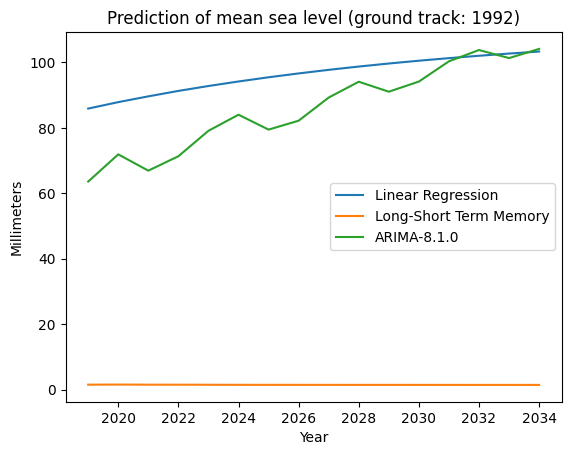

In [ ]:
colname = 'sea_level'
d = df[colname].dropna()
p1 = arima_extrapolate(d.iloc[:-5], (8, 1, 0), 15, log=False )

plt.plot(p1.index, ytest_pred_lr_sea, label='Linear Regression')
plt.plot(p1.index, ypred_sea_LSTM, label='Long-Short Term Memory')
plt.plot(p1.index, p1.values, label='ARIMA-8.1.0')
plt.xlabel("Year")
plt.ylabel("Millimeters")
plt.title("Prediction of mean sea level (ground track: 1992)")
plt.legend()

#### Surface Temperature from 2025 to 2040

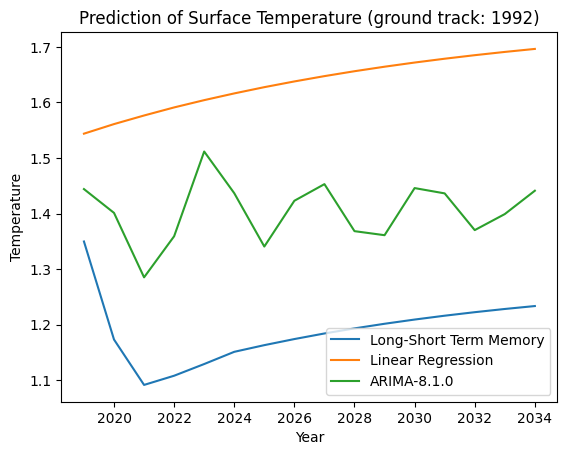

In [ ]:
colname = 'Degree Celsius'
d = df[colname].dropna()
p3 = arima_extrapolate(d.iloc[:-3], (8, 1, 0), 15, log=False)
plt.plot(p3.index, ypred_temperature_LSTM, label='Long-Short Term Memory')
plt.plot(p3.index, y_test_pred_lr_degree, label='Linear Regression')

plt.plot(p3.index, p3.values, label='ARIMA-8.1.0')
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Prediction of Surface Temperature (ground track: 1992)")
plt.legend()